./akaza-box-office-revenue-forecast.png has been saved.


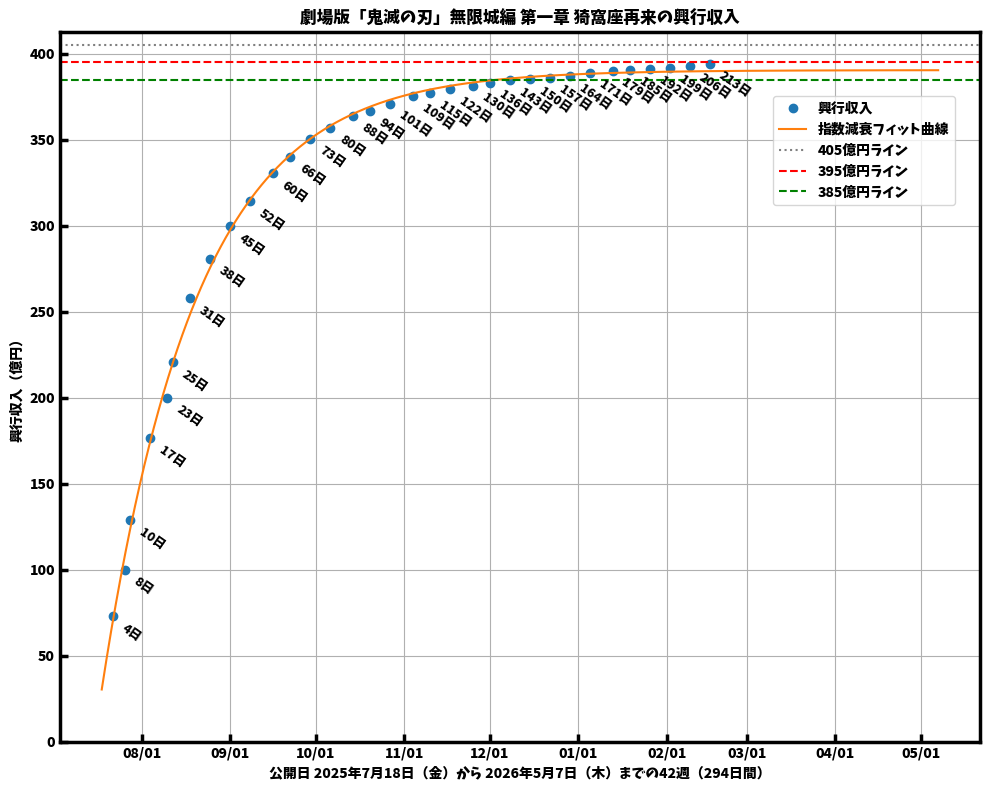

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.backends.backend_agg
import numpy as np
from scipy.optimize import curve_fit


# Create a canvas with Agg backend then save it as a file.
#     canvas = matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
#     canvas.print_figure(file_name, dpi=300)
#     print(file_name + ' has been saved.')
# You can show the plot on the display, too.
#     show.plt

FILE_NAME = "./akaza-box-office-revenue-forecast.png"

# 日本語フォント
# plt.rcParams["font.family"] = "Noto Sans CJK JP"
# plt.rcParams["font.family"] = "Natsume"
plt.rcParams["font.family"] = "Keifont"

GRAPF_TITLE = "劇場版「鬼滅の刃」無限城編 第一章 猗窩座再来の興行収入"

# 2026年5月7日（木）42週（294日間）までプロット
MAX_DAY = 293

# ターゲットライン
TARGET = 395
T_DELTA = 10
TARGET_LABLE_1 = f"{TARGET + T_DELTA}億円ライン"
TARGET_LABEL_2 = f"{TARGET}億円ライン"
TARGET_LABEL_3 = f"{TARGET - T_DELTA}億円ライン"

X_LEGEND = "興行収入"
FIT_LEGEND = "指数減衰フィット曲線"

X_LABLE = "公開日 2025年7月18日（金）から 2026年5月7日（木）までの42週（294日間）"
Y_LABLE = "興行収入（億円）"


# データ
days = np.array(
    [
        4, 8, 10, 17,
        23, 25, 31, 38,
        45, 52, 60,
        66, 73, 80, 88,
        94, 101, 109, 115,
        122, 130, 136, 143,
        150, 157, 164, 171,
        179, 185, 192, 199,
        206, 213
    ]
)
revenue = np.array(
    [
        73.158, 100.0, 128.722, 176.396,
        200.0, 220.722, 257.827, 280.877,
        299.835, 314.259, 330.561,
        340.115, 350.643, 357.0, 364.0,
        367.0, 371.0, 375.3, 377.0,
        379.276, 381.5, 383.3, 384.6,
        385.3, 386.1, 387.1, 389.0,
        390.3, 390.8, 391.4, 391.9,
        393.2,394.3
    ]
)

# 公開日
release_date = datetime(2025, 7, 18)
dates = np.array([release_date + timedelta(days=int(d)) for d in days])


# 指数減衰モデル（オーバーフロー防御あり）
def exp_decay(x, A, B, k):
    z = -k * x
    # exp のオーバーフローを防ぐクリップ（安全側）
    z = np.clip(z, -700, 700)
    return A - B * np.exp(z)


# フィット: 初期値 p0 をデータから自動算出し、k>=0 を制約する
A0 = max(revenue[-1], revenue.max()) * 1.02
B0 = max(A0 - revenue[0], 1e-6)
i1, i2 = 0, min(4, len(days) - 1)
y1, y2 = revenue[i1], revenue[i2]
x1, x2 = days[i1], days[i2]
if (A0 - y1) > 0 and (A0 - y2) > 0 and x2 != x1:
    K0 = -np.log((A0 - y2) / (A0 - y1)) / (x2 - x1)
    if not np.isfinite(K0) or K0 <= 0:
        K0 = 0.02
else:
    K0 = 0.02
p0 = [A0, B0, K0]
bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])  # k>=0 を強制
popt, pcov, *_ = curve_fit(exp_decay, days, revenue, p0=p0, bounds=bounds, maxfev=100000)
A, B, k = popt

x_fit = np.linspace(0, MAX_DAY, 3000)
y_fit = exp_decay(x_fit, A, B, k)
dates_fit = np.array([release_date + timedelta(days=float(d)) for d in x_fit])

# プロット
fig, ax = plt.subplots(figsize=(10, 8))

# 凡例位置
LEGEND_LOC = "upper right"
LEGEND_BBOX = (0.98, 0.92)
LEGEND_NCOL = 1

# 枠線（spines）と目盛線を太くする
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
# 目盛り線を太くし、グラフの内側に。
ax.tick_params(width=2.5, direction="in", length=6)

# 実測データ
ax.plot(dates, revenue, "o", label=X_LEGEND)

# 指数減衰フィット曲線
ax.plot(dates_fit, y_fit, "-", label=FIT_LEGEND)

# ターゲットライン
ax.axhline(TARGET + T_DELTA, color="grey", linestyle="dotted", label=TARGET_LABLE_1)
ax.axhline(TARGET, color="red", linestyle="--", label=TARGET_LABEL_2)
ax.axhline(TARGET - T_DELTA, color="green", linestyle="--", label=TARGET_LABEL_3)

# 各点に日数注釈
for d, r, day in zip(dates, revenue, days):
    ax.annotate(
        f"{day}日",
        xy=(d, r),
        xytext=(6, -10),
        textcoords="offset points",
        fontsize=9,
        ha="left",
        rotation=-35,
        weight="bold",
        rotation_mode="anchor",
    )

# 軸設定
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.set_xlabel(X_LABLE)
ax.set_ylabel(Y_LABLE)

# 目盛りラベルを全て太字にする（x軸・y軸）
for label in ax.get_xticklabels():
    label.set_fontweight("bold")
for label in ax.get_yticklabels():
    label.set_fontweight("bold")

ax.set_title(
    label=GRAPF_TITLE,
    fontweight="bold",
)

ax.grid(True)
ax.legend(loc=LEGEND_LOC, bbox_to_anchor=LEGEND_BBOX, ncol=LEGEND_NCOL)
plt.tight_layout()
ax.set_ylim(bottom=0)

canvas = matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
canvas.print_figure(FILE_NAME, dpi=300)
print(FILE_NAME + ' has been saved.')

plt.show()
